In [323]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import geopandas as gpd
import folium
from utils._03_OxxoCleaningOutliers import GetGeoDistance, GetClosestPoint
from utils._03_OxxoCleaningOutliers import ParserPointsPlotly, PlotPlottlyMapBox

In [2]:
sns.set_theme(palette="bright")

### Cargando datos

In [3]:
# Loading geographic information about mexico city
boroughs_cdmx_gdf = gpd.read_file("../data/oxxo/boroughs_cdmx.geojson")
boroughs_cdmx_gdf = boroughs_cdmx_gdf.rename_geometry("boroughs_geometry")
boroughs_cdmx_gdf.boroughs_name = boroughs_cdmx_gdf.boroughs_name.str.replace(".", "", regex=False)
boroughs_cdmx_gdf.boroughs_name = boroughs_cdmx_gdf.boroughs_name.str.replace("\s+"," ", regex=True)


neighborhoods_cdmx_gdf = gpd.read_file("../data/oxxo/neighborhoods_cdmx.geojson")
neighborhoods_cdmx_gdf = neighborhoods_cdmx_gdf.rename_geometry("neighborhoods_geometry")

cdmx_metadata_gdf = boroughs_cdmx_gdf.merge(neighborhoods_cdmx_gdf, on="index", how="inner")
cdmx_metadata_gdf.drop("index", axis=1, inplace=True)

cdmx_metadata_gdf.head()

boroughs_id boroughs_name  boroughs_population  \
0       09002  azcapotzalco               432205   
1       09002  azcapotzalco               432205   
2       09002  azcapotzalco               432205   
3       09002  azcapotzalco               432205   
4       09002  azcapotzalco               432205   

                                   boroughs_geometry neighborhoods_id  \
0  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010383   
1  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010379   
2  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    090020001067A   
3  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010699   
4  POLYGON ((-99.18231 19.50748, -99.18229 19.507...    0900200010260   

   neighborhoods_avg_income_quarterly  \
0                             34629.3   
1                             33061.7   
2                             44264.7   
3                             47045.3   
4                             59562.1   

                              neighborhoods_geometry  
0  POLYGON ((-99.15142 19.47910, -99.15152 19.478...  
1  POLYGON ((-99.15813 19.47749, -99.15824 19.477...  
2  POLYGON ((-99.18126 19.47366, -99.18115 19.473...  
3  POLYGON ((-99.17616 19.46819, -99.17657 19.467...  
4  POLYGON ((-99.19685 19.49267, -99.19640 19.492...

In [4]:
# Loading clean oxxo data
oxxo_df = pd.read_csv("../data/oxxo/oxxo_clean_data.csv")
oxxo_df["Subregion"] = oxxo_df.Subregion.str.replace(".", "", regex=False)
oxxo_df["Subregion"] = oxxo_df.Subregion.str.replace("\s+"," ", regex=True)

oxxo_df.head(2)

latitude  longitude           name  comments  rating  \
0  19.353753 -99.189937  OXXO Helenico       4.0     4.3   
1  19.348316 -99.185520    Oxxo La Paz      13.0     3.5   

                               Address Neighborhood           City  Postal  \
0                   Avenida Revolución     Sn Ángel  Guadalupe Inn  1020.0   
1  Avenida Miguel Ángel de Quevedo 36B          NaN    Chimalistac  1050.0   

        Subregion            Region  Bajo  Medio Bajo  Medio Alto  Alto  
0  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0  
1  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0

### Distancia mínima entre dos oxxos

In [5]:
# Getting matrix distance
oxxo_points_numpy = oxxo_df[["latitude","longitude"]].to_numpy()

matrix_distance_oxxo = GetGeoDistance(oxxo_points_numpy)
np.fill_diagonal(matrix_distance_oxxo, np.inf)

In [6]:
# Getting closest points
oxxo_closest_distance = GetClosestPoint(oxxo_points_numpy, matrix_distance_oxxo)
oxxo_closest_distance

point_a                    point_b  index_a  index_b  \
0     (19.3537529, -99.1899374)  (19.3519153, -99.1869152)        0      126   
1     (19.3483164, -99.1855199)    (19.351655, -99.185903)        1      107   
2     (19.3416291, -99.2030682)  (19.3394322, -99.2038138)        2       16   
3     (19.3609272, -99.1852465)  (19.3599485, -99.1831651)        3       11   
4     (19.3580665, -99.1844114)  (19.3599485, -99.1831651)        4       11   
...                         ...                        ...      ...      ...   
1665   (19.4093558, -99.120045)  (19.4078033, -99.1214175)     1665      932   
1666  (19.4151761, -99.1042633)  (19.4172241, -99.1026671)     1666     1388   
1667  (19.2631302, -99.1053816)  (19.2604749, -99.1111195)     1667     1114   
1668  (19.2739901, -99.1241512)  (19.2743458, -99.1206057)     1668     1669   
1669  (19.2743458, -99.1206057)  (19.2772486, -99.1220439)     1669     1072   

        distance  
0     377.104110  
1     371.756224  
2     255.496556  
3     244.044214  
4     246.063624  
...          ...  
1665  224.312447  
1666  281.959476  
1667  671.006107  
1668  374.771276  
1669  355.114174  

[1670 rows x 5 columns]

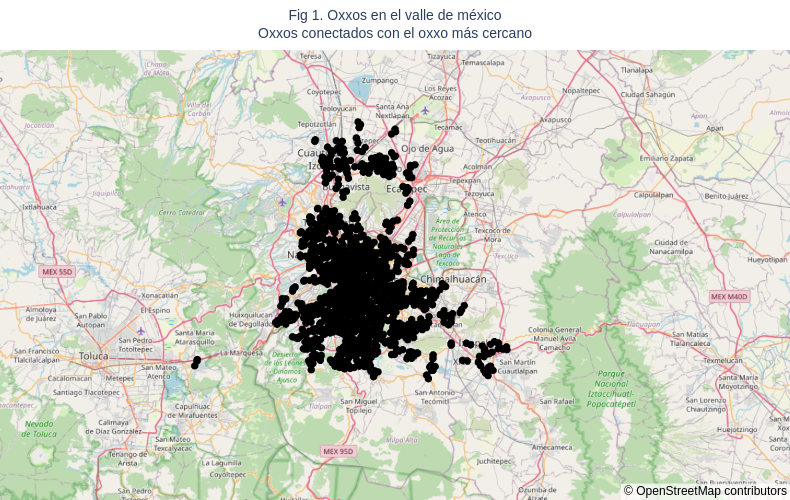

In [7]:
latitude, longitude, distance = ParserPointsPlotly(oxxo_closest_distance.point_a,
                    oxxo_closest_distance.point_b,
                    oxxo_closest_distance.distance)

oxxo_map = PlotPlottlyMapBox(longitude, latitude, distance)
oxxo_map.update_layout(
    title="Fig 1. Oxxos en el valle de méxico<br>Oxxos conectados con el oxxo más cercano",
    font={"size":10},
    title_x=0.5,
    title_y=0.96,
    margin={"l": 0, "r": 0, "b": 0, "t": 50},
    height=500
)
oxxo_map.show()

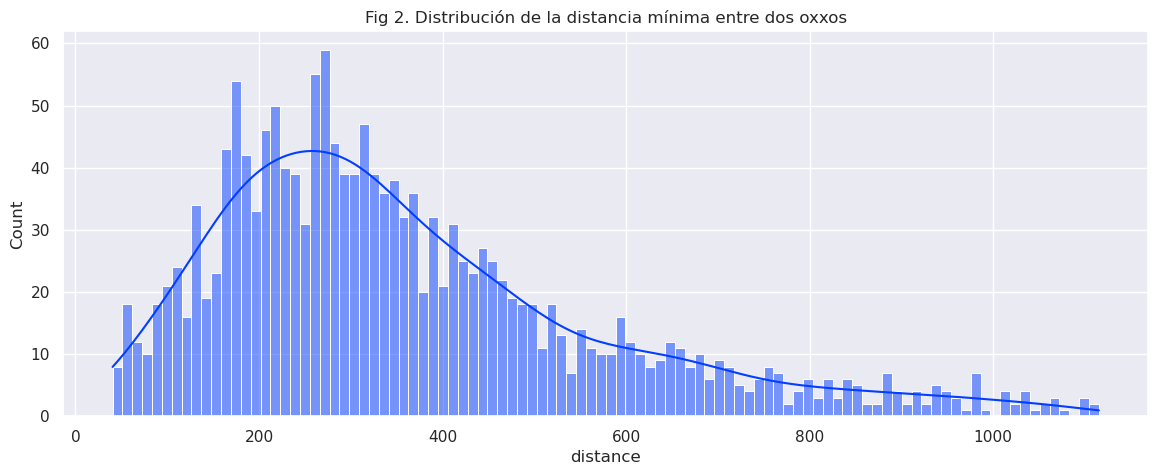

In [8]:
fig, axis = plt.subplots(1,1, figsize=(14,5))
sns.histplot(oxxo_closest_distance.distance, kde=True, bins=100, ax=axis)
axis.set_title("Fig 2. Distribución de la distancia mínima entre dos oxxos")
plt.show()

In [9]:
oxxo_closest_distance.distance.describe()

count    1670.000000
mean      363.854741
std       213.341883
min        40.407969
25%       210.848744
50%       313.328076
75%       463.828876
max      1115.078610
Name: distance, dtype: float64

In [10]:
oxxo_closest_distance.distance.quantile(0.9)

671.2890232342353

75% de los oxxos se encuentran a una distancia de entre 40 metros a 463 metros, y 90% de aquellos de 40 a 671 metros. Recordemos que la distancia mínima y máxima fue truncada a 40 metros y 1125 metros (con la pérdida del 9.5% de información con respecto al data set original, para más detalles ver 03_OxxoCleaningOutliers.ipynb). La distancia mínima entre dos oxxos en la ciudad de méxico y parte del valle de méxico, corresponde usualmente a 313 metros (mediana 313.32 m.) o aproximadamente a una distancia caminable de aproximadamente 5 minutos entre oxxos (1 kilometro = 15 minutos)

### Conexiones entre oxxos

In [11]:
oxxo_points_index = oxxo_closest_distance[["index_a", "index_b"]].to_numpy()
oxxo_graph = nx.Graph()
oxxo_graph.add_edges_from(oxxo_points_index)

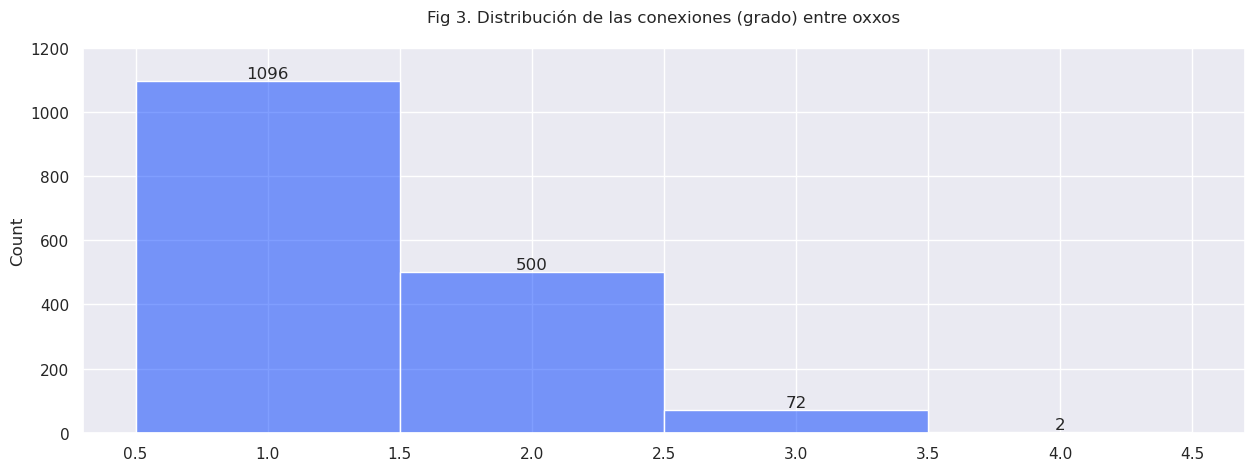

In [12]:
degrees = dict(oxxo_graph.degree).values()

fig, axis = plt.subplots(1,1, figsize=(15,5))
sns.histplot(degrees, discrete=True, legend=False, ax=axis)

axis.bar_label(axis.containers[1])
axis.set_title("Fig 3. Distribución de las conexiones (grado) entre oxxos\n")
axis.set_ylim(0, 1200)
plt.show()

Alrededor del 65.62% de los oxxos en el valle de méxico están conectados sólo a otro oxxo considerando su distancia mínima, así mismo, casi 30% de los oxxos están conectados a dos oxxos. Encontrar una tienda que esté conectada ya sea a 3 o 4 oxxos no es algo común y, por ende, oxxos actuando como "puntos" centrales para otros oxxos parece raro bajo la definición estudiada

In [13]:
weight = np.column_stack([oxxo_points_index,
                          np.array(oxxo_closest_distance.distance)])

oxxo_graph.add_weighted_edges_from(weight)

In [14]:

degree_df = pd.DataFrame(oxxo_graph.degree(), columns=["node","degree"])
weight_df = pd.DataFrame(oxxo_graph.degree(weight="weight"), columns=["node", "weight"])

degree_weight_df = degree_df.merge(weight_df, how="inner", on="node")

degree_weight_df["avg_distance"] = degree_weight_df.weight / degree_weight_df.degree

degree_weight_df.head()

node  degree       weight  avg_distance
0     0       2   864.319234    432.159617
1   126       2   487.289012    243.644506
2     1       1   371.756224    371.756224
3   107       2   481.941126    240.970563
4     2       2  1043.734428    521.867214

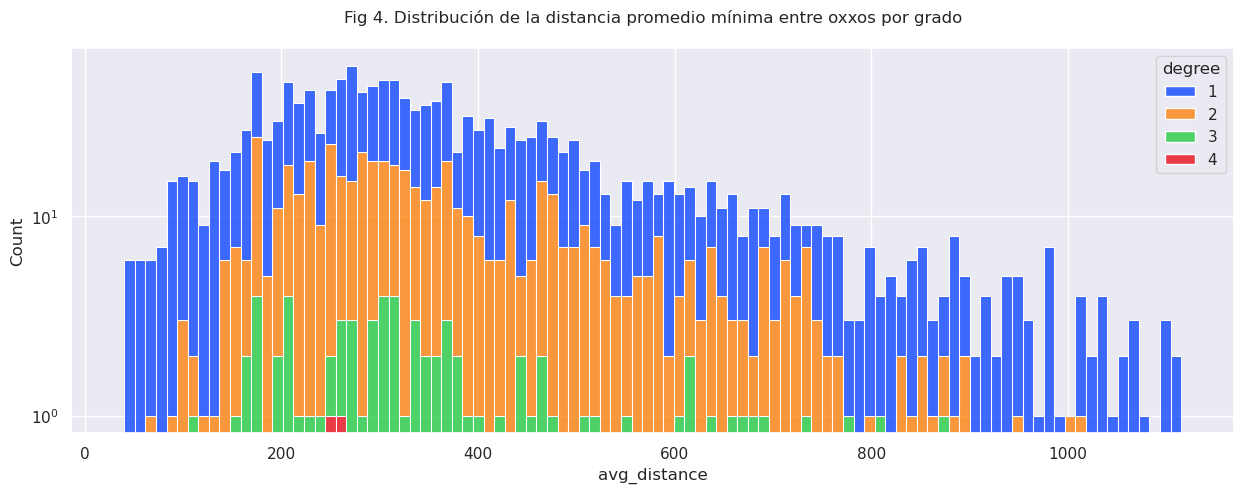

In [15]:
colors = sns.palettes.color_palette("bright", 4)

fig, axis = plt.subplots(1,1, figsize=(15,5))

sns.histplot(data=degree_weight_df, x="avg_distance",
                 hue="degree", multiple="stack", 
                 palette=colors, ax=axis, bins=100)

axis.set_yscale("log")
axis.set_title("Fig 4. Distribución de la distancia promedio mínima entre oxxos por grado\n")
plt.show()

El comportamiento de las distancias entre oxxos es similar en términos de su grado siempre y cuando una tienda tiene una, o dos tiendas más cerca de aquel (< 1125 metros). Ésta tendencia es difícil de discutir para aquellos oxxos conectados a más de tres tiendas

### Probabilidades de encontrar un oxxo

Por otro lado, ¿Cuál es la probabilidad de que haya N oxxos "cerca" de otro oxxo? Vamos a probarlo para diferentes definiciones de "cerca" (1000, 800, 600, 400 metros)

In [16]:
def GetDistribution(matrix_distance:np.array,
                    threshold:int|float,
                    prob:bool=False) -> pd.DataFrame:
    
    sample_size = matrix_distance.shape[0] 
    
    positive_cases = (matrix_distance < threshold).nonzero()
    positive_cases = np.transpose(positive_cases)
    
    weights = matrix_distance[positive_cases[:,0], positive_cases[:,1]]
    
    edges = np.column_stack((positive_cases, weights))

    g = nx.Graph()
    g.add_weighted_edges_from(edges)

    degrees_df = pd.DataFrame(g.degree(), columns=["node", "degree"])
    distribution = degrees_df.degree.value_counts().to_frame()
    
    distribution.reset_index(names=["case"], inplace=True)
    distribution.rename({"degree":"positive_cases"}, axis=1, inplace=True)

    n_negative_cases = sample_size - distribution.positive_cases.sum()

    negative_cases_df = pd.DataFrame({"case": [0], "positive_cases": n_negative_cases})

    distribution = pd.concat([negative_cases_df, distribution]).sort_values(by="case")
    
    if prob:
        
        distribution.positive_cases = distribution.positive_cases / sample_size
    
    return(g, distribution.reset_index(drop=True))

In [17]:
distributions_per_dist = []
graphs = []
close_def = [1000, 800, 600, 400]

for close in close_def:
    g, df = GetDistribution(matrix_distance_oxxo, close, True)
    
    graphs.append(g)
    distributions_per_dist.append(df)
    

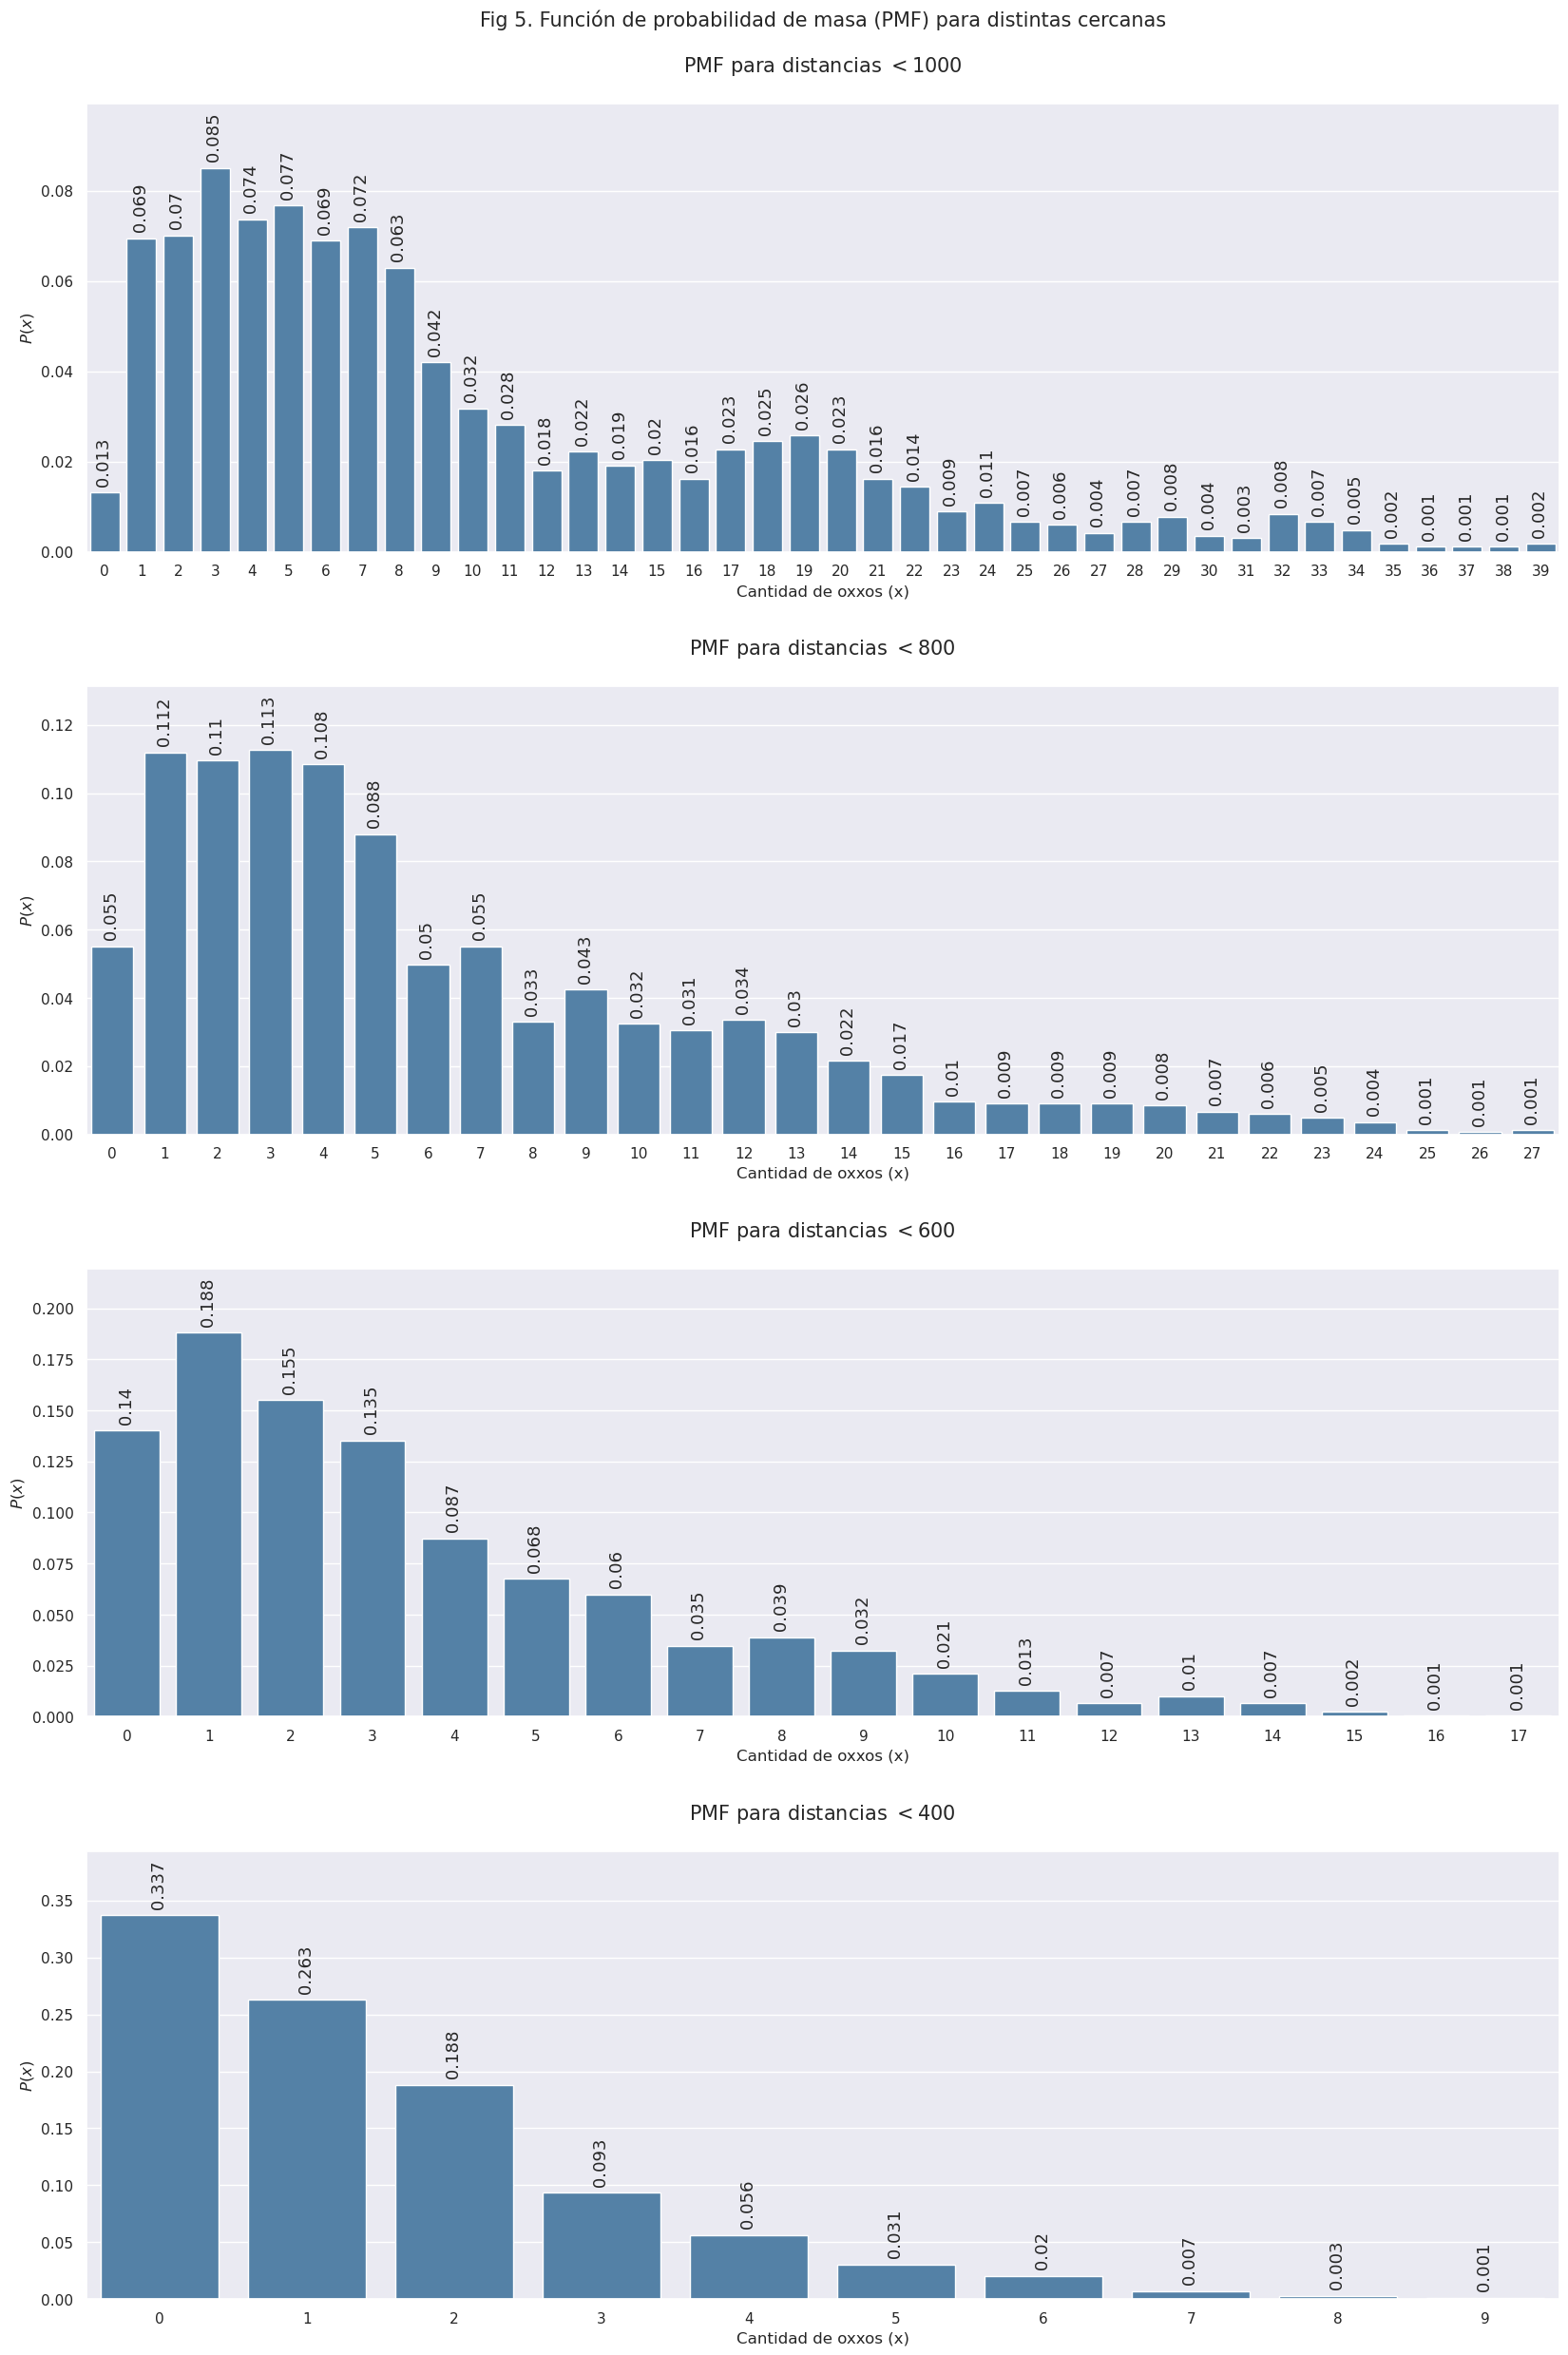

In [18]:
fig, axis = plt.subplots(4,1, figsize=(20,30))

for df, dist, ax in zip(distributions_per_dist, close_def, axis):
    
    sns.barplot(x = df["case"], y = df["positive_cases"],
                ax = ax, color="steelblue")
    
    top_limit = df["positive_cases"].max() + (df["positive_cases"].max() / 6)
    ax.set_ylim(0, top_limit)
    ax.set_title(f"PMF para distancias $< {dist}$\n", fontsize=15)
    
    labels = [" " + str(round(i,3)) for i in ax.containers[0].datavalues]
    ax.bar_label(ax.containers[0], labels=labels, fmt="%.3f", fontsize=13, rotation=90)
    ax.set_ylabel("$P(x)$")
    ax.set_xlabel("Cantidad de oxxos (x)")

axis[0].set_title(f"Fig 5. Función de probabilidad de masa (PMF) para distintas cercanas\n\nPMF para distancias $< {close_def[0]}$\n", fontsize=15 )
plt.subplots_adjust(hspace=0.3)
plt.show()

### Mejor/Peor oxxo

In [19]:
# Removing NaN
mask_nan = ~oxxo_df[["rating","comments"]].isna().any(axis=1)

oxxo_scores_df = oxxo_df[mask_nan][["rating","comments"]]
oxxo_scores_df["comments_rank_score"] = oxxo_scores_df.comments.rank(pct=True)
oxxo_scores_df["oxxo_score"] = oxxo_scores_df["rating"] * oxxo_scores_df["comments_rank_score"]

oxxo_scores_df = oxxo_scores_df.sort_values(by="oxxo_score", ascending=False)
top_five = oxxo_scores_df.head()

buttom_five = oxxo_scores_df.sort_values(by="oxxo_score").head()

columns_to_drop = ["Neighborhood", "Postal",
                   "Bajo","Medio Bajo",
                   "Medio Alto","Alto",
                   "Address", "City", 
                   "Subregion", "Region", 
                   "comments_x","rating_x",
                   "comments_rank_score"]

rename = {"name": "Name",
        "oxxo_score": "Score",
        "comments_y": "Reviews",
        "rating_y": "Rating",
        "address": "Address",
        "latitude": "Latitude",
        "longitude": "Longitude"}

top_five = oxxo_df.loc[top_five.index].merge(top_five, left_index=True, right_index=True)
address_top_five = top_five[["Address", "City", "Subregion", "Region"]].fillna("NaN")
address_top_five = address_top_five.apply(lambda x: ", ".join(x), axis=1)

top_five["address"] = address_top_five.values
top_five.drop(columns_to_drop, inplace=True, axis=1)
top_five.rename(rename, axis=1, inplace=True)

buttom_five = oxxo_df.loc[buttom_five.index].merge(buttom_five, left_index=True, right_index=True)
address_buttom_five = buttom_five[["Address", "City", "Subregion", "Region"]].fillna("")
address_buttom_five = address_buttom_five.apply(lambda x: ", ".join(x), axis=1)

buttom_five["address"] = address_buttom_five.values
buttom_five.drop(columns_to_drop, inplace=True, axis=1)
buttom_five.rename(rename, axis=1, inplace=True)

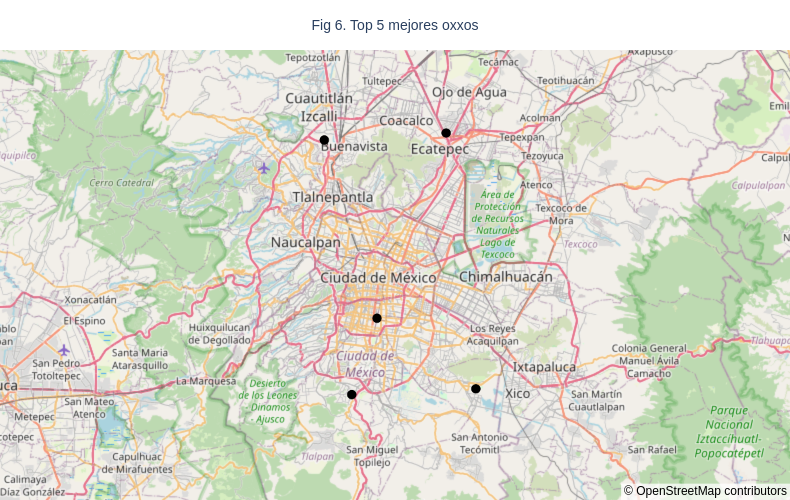

In [20]:
top_five_fig = px.scatter_mapbox(data_frame = top_five, mapbox_style="open-street-map",
                                 lat="Latitude", lon="Longitude",
                                 hover_data=list(top_five.columns))

top_five_fig.update_traces(marker={"size":10, "color":"black"})
top_five_fig.update_layout(
    title="Fig 6. Top 5 mejores oxxos",
    font={"size":10},
    title_x=0.5,
    title_y=0.96,
    margin={"l": 0, "r": 0, "b": 0, "t": 50},
    height=500,
    mapbox={"zoom":9}
)
top_five_fig.show()

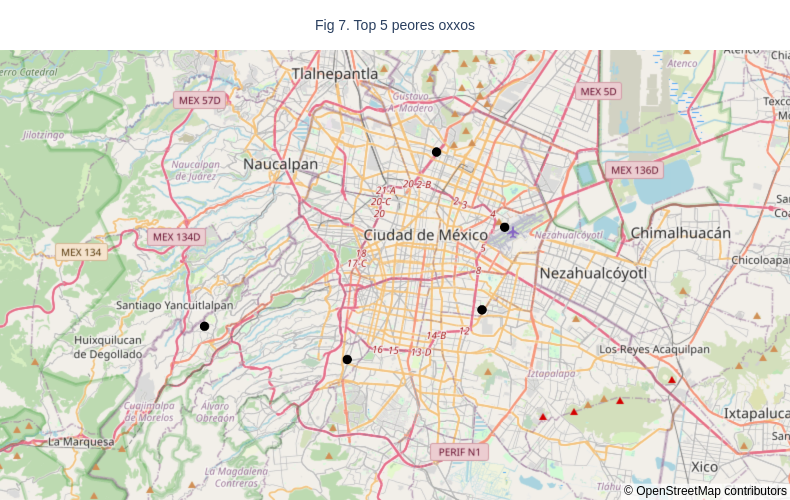

In [21]:
buttom_five_fig = px.scatter_mapbox(data_frame = buttom_five, mapbox_style="open-street-map",
                                 lat="Latitude", lon="Longitude",
                                 hover_data=list(buttom_five.columns))

buttom_five_fig.update_traces(marker={"size":10, "color":"black"})
buttom_five_fig.update_layout(
    title="Fig 7. Top 5 peores oxxos",
    font={"size":10},
    title_x=0.5,
    title_y=0.96,
    margin={"l": 0, "r": 0, "b": 0, "t": 50},
    height=500,
    mapbox={"zoom":10}
)
buttom_five_fig.show()

### Densidad de oxxos

In [122]:
cdmx_boroughs_df = cdmx_metadata_gdf.iloc[:,:4].drop_duplicates()

cdmx_boroughs_area = cdmx_boroughs_df.boroughs_geometry.to_crs("EPSG:32614").area
cdmx_boroughs_area = cdmx_boroughs_area / (1000 * 1000)

cdmx_boroughs_df["area_km2"] = cdmx_boroughs_area.values

oxxo_boroughs_cdmx = oxxo_df.merge(cdmx_boroughs_df,
                                   how="right",
                                   right_on="boroughs_name",
                                   left_on="Subregion")

oxxo_boroughs_cdmx.head()

latitude  longitude                name  comments  rating  \
0  19.478012 -99.200186       OXXO Cantemoc      10.0     2.8   
1  19.470469 -99.189791                Oxxo      15.0     3.8   
2  19.484479 -99.185800    Oxxo Castilla MR      34.0     2.9   
3  19.478852 -99.189039       OXXO Apolonia      17.0     3.1   
4  19.481556 -99.182440  Oxxo San Sebastián      14.0     3.4   

                  Address Neighborhood                    City  Postal  \
0          Campo Cantemoc          NaN             San Antonio  2720.0   
1  Avenida Aquiles Serdán          NaN           Ángel Zimbrón  2099.0   
2    Avenida Azcapotzalco          NaN  Centro de Azcapotzalco  2000.0   
3          Santa Apolonia          NaN  San Francisco Tetecala  2730.0   
4                 Calle 2          NaN             Del Maestro  2040.0   

      Subregion            Region  Bajo  Medio Bajo  Medio Alto  Alto  \
0  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
1  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
2  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
3  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   
4  azcapotzalco  ciudad de méxico   NaN        40.0        47.0  23.0   

  boroughs_id boroughs_name  boroughs_population  \
0       09002  azcapotzalco               432205   
1       09002  azcapotzalco               432205   
2       09002  azcapotzalco               432205   
3       09002  azcapotzalco               432205   
4       09002  azcapotzalco               432205   

                                   boroughs_geometry   area_km2  
0  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
1  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
2  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
3  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385  
4  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  33.496385

In [123]:
columns_density = ["boroughs_name", "boroughs_population", "area_km2"]
density_oxxo_df = oxxo_boroughs_cdmx[columns_density]
density_oxxo_df = density_oxxo_df.groupby(columns_density).value_counts().to_frame().reset_index()

density_oxxo_df.rename({0:"n_oxxo"}, inplace=True, axis=1)

density_oxxo_df["oxxo_density_area"] = density_oxxo_df.n_oxxo / density_oxxo_df.area_km2
density_oxxo_df["oxxo_density_population_100k"] = density_oxxo_df.n_oxxo / density_oxxo_df.boroughs_population
density_oxxo_df["oxxo_density_population_100k"] = density_oxxo_df.oxxo_density_population_100k * 100_000

density_oxxo_df.head()

boroughs_name  boroughs_population   area_km2  n_oxxo  \
0         alvaro obregon               759137  95.819633     101   
1           azcapotzalco               432205  33.496385      67   
2          benito juarez               434153  26.680071     162   
3               coyoacan               614447  53.879871      98   
4  cuajimalpa de morelos               217686  71.102696      31   

   oxxo_density_area  oxxo_density_population_100k  
0           1.054064                     13.304581  
1           2.000216                     15.501903  
2           6.071948                     37.314034  
3           1.818861                     15.949301  
4           0.435989                     14.240695

In [124]:
polygon_cdmx = cdmx_boroughs_df[["boroughs_name", "boroughs_geometry"]]
density_oxxo_df = density_oxxo_df.merge(polygon_cdmx, on="boroughs_name")

density_oxxo_df = gpd.GeoDataFrame(density_oxxo_df)
density_oxxo_df = density_oxxo_df.set_geometry("boroughs_geometry")

In [125]:
rename = {"boroughs_name":"Alcaldía", "boroughs_population":"Población",
          "area_km2":"Área in $km^2$","n_oxxo":"Cantidad de Oxxos",
          "oxxo_density_area":"Densidad por área",
          "oxxo_density_population_100k":"Densidad por 100k habitantes"}

density_oxxo_df.rename(rename, axis=1, inplace=True)
density_oxxo_df.head()

Alcaldía  Población  Área in $km^2$  Cantidad de Oxxos  \
0         alvaro obregon     759137       95.819633                101   
1           azcapotzalco     432205       33.496385                 67   
2          benito juarez     434153       26.680071                162   
3               coyoacan     614447       53.879871                 98   
4  cuajimalpa de morelos     217686       71.102696                 31   

   Densidad por área  Densidad por 100k habitantes  \
0           1.054064                     13.304581   
1           2.000216                     15.501903   
2           6.071948                     37.314034   
3           1.818861                     15.949301   
4           0.435989                     14.240695   

                                   boroughs_geometry  
0  POLYGON ((-99.18906 19.39559, -99.18871 19.394...  
1  POLYGON ((-99.18231 19.50748, -99.18229 19.507...  
2  POLYGON ((-99.14762 19.40401, -99.14681 19.403...  
3  POLYGON ((-99.13427 19.35654, -99.13397 19.356...  
4  POLYGON ((-99.25738 19.40112, -99.25698 19.400...

In [326]:
density_km2_fig = density_oxxo_df.explore("Densidad por área", legend=True,
                                     style_kwds={"fillOpacity":0.8}, cmap="magma",
                                     vmin=0, vmax=10,
                                     zoom_start=9)

title_text = "Fig 8. Densidad de oxxos por km^2"
title_format = '''
        <h3 align="center" style="font-size:14px"><b>{}</b></h3>
        '''.format(title_text)

density_km2_fig.get_root().html.add_child(folium.Element(title_format))
density_km2_fig

In [325]:
density_popu_fig = density_oxxo_df.explore("Densidad por 100k habitantes", legend=True,
                                      style_kwds={"fillOpacity":0.8}, cmap="copper",
                                      vmin=0,  vmax=40,
                                      zoom_start=9)

title_text = "Fig 8. Densidad de oxxos por 100k habitantes"
title_format = '''
        <h3 align="center" style="font-size:14px"><b>{}</b></h3>
        '''.format(title_text)

density_popu_fig.get_root().html.add_child(folium.Element(title_format))
density_popu_fig